In [1]:
import json
import glob, pickle
from collections import defaultdict

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder, random_clifford_circuit
from gnn import ExpValCircuitGraphModel
from qiskit.quantum_info import Clifford

In [2]:
backend_name = 'fakemontreal'

if backend_name == 'fakelima':
    backend = FakeLima()
    properties = get_backend_properties_v1(backend)

    ## Local
    backend_ideal = QasmSimulator() # Noiseless
    backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

    run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
    run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy_lima'}

elif backend_name == 'fakebelem':
    backend = FakeBelem()
    properties = get_backend_properties_v1(backend)

    ## Local
    backend_ideal = QasmSimulator() # Noiseless
    backend_noisy = AerSimulator.from_backend(FakeBelem()) # Noisy

    run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
    run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy_belem'}

elif backend_name == 'fakemontreal':
    backend = FakeMontreal()
    properties = get_backend_properties_v1(backend)

    ## Local
    backend_ideal = QasmSimulator() # Noiseless
    backend_noisy = AerSimulator.from_backend(FakeMontreal()) # Noisy

    run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
    run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy_montreal'}

else:
    raise NotImplementedError

run_config_noisy

{'shots': 10000,
 'backend': AerSimulator('aer_simulator(fake_montreal)'
              noise_model=<NoiseModel on ['reset', 'cx', 'id', 'x', 'sx', 'measure']>),
 'name': 'noisy_montreal'}

In [3]:
files = sorted(glob.glob('./data/circ_linked_to_pyg_data/*.txt'))
files

['./data/circ_linked_to_pyg_data/qasm_11_-0.1.txt',
 './data/circ_linked_to_pyg_data/qasm_11_-0.2.txt',
 './data/circ_linked_to_pyg_data/qasm_11_-0.3.txt',
 './data/circ_linked_to_pyg_data/qasm_11_-0.4.txt',
 './data/circ_linked_to_pyg_data/qasm_11_-0.5.txt',
 './data/circ_linked_to_pyg_data/qasm_11_-0.6.txt',
 './data/circ_linked_to_pyg_data/qasm_11_-0.7.txt',
 './data/circ_linked_to_pyg_data/qasm_11_-0.8.txt',
 './data/circ_linked_to_pyg_data/qasm_11_-0.9.txt',
 './data/circ_linked_to_pyg_data/qasm_11_-1.0.txt',
 './data/circ_linked_to_pyg_data/qasm_11_0.0.txt',
 './data/circ_linked_to_pyg_data/qasm_11_0.1.txt',
 './data/circ_linked_to_pyg_data/qasm_11_0.2.txt',
 './data/circ_linked_to_pyg_data/qasm_11_0.3.txt',
 './data/circ_linked_to_pyg_data/qasm_11_0.4.txt',
 './data/circ_linked_to_pyg_data/qasm_11_0.5.txt',
 './data/circ_linked_to_pyg_data/qasm_11_0.6.txt',
 './data/circ_linked_to_pyg_data/qasm_11_0.7.txt',
 './data/circ_linked_to_pyg_data/qasm_11_0.8.txt',
 './data/circ_linked_

In [ ]:
circs = defaultdict(list)

#for file in tqdm_notebook(files, leave=False):
for file in ['./data/circ_linked_to_pyg_data/qasm_11_-0.3.txt']:
    print(file)
    depth = int(file.split('_')[-2])
    if depth not in [3, 5, 7, 9, 11]:
        continue
    # exp_val_bin = float(file.split('_')[-1][:-4])

    # f_name = '_'.join([depth, round(exp_val_bin, 1)]) + '.json'
    f_name = file.split('/')[-1][5:-4] + '.json'
    with open('./data/pyg_data/'+f_name, 'r') as in_f:
        pyg_dicts = json.load(in_f)
        print('len(pyg_dicts)\t', len(pyg_dicts))

    qc_list = []
    with open(file, "r") as f:
        lines = f.read().split('-----')
        print('len(lines)\t', len(lines) - 1)
        print('exp_val, \t ideal_exp_value, \t noisy_exp_values')
        for i, line in enumerate(lines):
            splitted = line.split('\n')
            valid = splitted[3:]
            if len(valid) and valid[0].startswith('qasm'):
                valid = valid[1:]
            elif not len(valid):
                continue
            try:
                exp_val = float(splitted[1])
            except:
                exp_val = float(splitted[2])
            qasm_str = '\n'.join(valid)
            qc = QuantumCircuit.from_qasm_str(qasm_str)
            pyg_dict = pyg_dicts[i]
            print(exp_val, pyg_dict['ideal_exp_value'], pyg_dict['noisy_exp_values'])
            qc_list.append((exp_val, qc, pyg_dict))
    print('len(qc_list)', len(qc_list))
    circs[depth] += qc_list

In [106]:
# with open('./data/circ_parsed_pyg_data/parsed.pk', 'wb') as out:
#     pickle.dump(circs, out)

In [78]:
from random import shuffle
import copy

new_parsed = {}
for d in range(1, 19):
    if not len(parsed[float(d)]): continue
    print(len(parsed[float(d)]))
    tmp = copy.deepcopy(parsed[float(d)])
    print(len(tmp))
    shuffle(tmp)
    new_parsed[int(d)] = tmp

1990
1990
1990
1990
1976
1976
1984
1984
1990
1990
1982
1982
1982
1982
1978
1978
1971
1971
1953
1953
1984
1984
1990
1990
1960
1960
1984
1984
1953
1953


In [79]:
# with open('./data/circ_parsed_pyg_data/new_parsed.pk', 'wb') as out:
#     pickle.dump(new_parsed, out)

In [4]:
with open('./data/circ_parsed_pyg_data/new_parsed.pk', 'rb') as in_f:
    new_parsed = pickle.load(in_f)

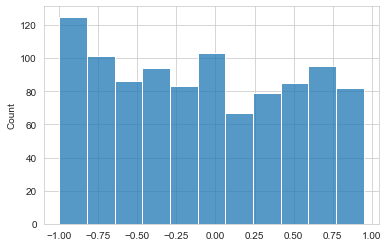

In [96]:
plt.style.use({'figure.facecolor':'white'})

for d in [4]:
    sns.histplot(list(zip(*new_parsed[d]))[0][:1000])

In [5]:
# with open('./data/pyg_data/3_0.0.json', 'r') as in_f:
#     pyg_d = json.load(in_f)

In [13]:
print(backend_name)
for depth, qc_list in tqdm_notebook(new_parsed.items()):
    circuits = list(list(zip(*qc_list))[1])
    if depth not in list(range(1, 10)): continue
    print(int(depth), len(circuits))
    entries = []
    # trian circuits[:1000]
    # val circuits[1000:1400]
    # finetune circuits[1400:1800]
    for circuit in tqdm_notebook(circuits[1000:1400]):
        job_ideal = execute(circuit, **run_config_ideal)
        job_noisy = execute(circuit, **run_config_noisy)

        counts_ideal = job_ideal.result().get_counts()
        counts_noisy = job_noisy.result().get_counts()

        ideal_exp_val = cal_all_z_exp(counts_ideal)
        noisy_exp_val = cal_all_z_exp(counts_noisy)

        graph_data = circuit_to_graph_data_json(
            circuit=circuit,
            properties=properties,
            use_qubit_features=True,
            use_gate_features=True,
        )

        entry = ExpValueEntry(
            circuit_graph=graph_data,
            observable=[],
            ideal_exp_value=[ideal_exp_val],
            noisy_exp_values=[[noisy_exp_val]],
            circuit_depth=circuit.depth()
        )
        to_append = entry.to_dict()
        to_append['circuit'] = circuit
        entries.append(to_append)

    print(len(entries))
    with open(f'./data/circ_parsed_pyg_data/val/{backend_name}_depth{depth}.pk', 'wb') as out_file:
        pickle.dump(entries, out_file)

fakemontreal


  0%|          | 0/15 [00:00<?, ?it/s]

1 1990


  0%|          | 0/400 [00:00<?, ?it/s]

400
2 1990


  0%|          | 0/400 [00:00<?, ?it/s]

400
3 1976


  0%|          | 0/400 [00:00<?, ?it/s]

400
4 1984


  0%|          | 0/400 [00:00<?, ?it/s]

400
5 1990


  0%|          | 0/400 [00:00<?, ?it/s]

400
6 1982


  0%|          | 0/400 [00:00<?, ?it/s]

400
7 1982


  0%|          | 0/400 [00:00<?, ?it/s]

400
8 1978


  0%|          | 0/400 [00:00<?, ?it/s]

400
9 1971


  0%|          | 0/400 [00:00<?, ?it/s]

400


In [10]:
with open(f'./data/circ_parsed_pyg_data/train/fakemontreal_depth1.json', 'r') as in_file:
    d = json.load(in_file)

In [55]:
for i in range(len(d)):
    print(d[i]['noisy_exp_values'], d[i]['ideal_exp_value'])

[[-0.1274]] [-0.1448]
[[0.0086]] [0.0096]
[[0.022]] [0.0028]
[[-0.0688]] [0.0074]
[[0.0104]] [-0.0014]
[[0.0804]] [0.0048]
[[-0.0288]] [-0.044]
[[-0.0098]] [-0.0142]
[[-0.0774]] [0.017]
[[0.0596]] [0.0038]
[[-0.0274]] [-0.1124]
[[0.075]] [-0.0128]
[[0.0368]] [0.0118]
[[-0.098]] [-0.0916]
[[-0.033]] [0.003]
[[0.0266]] [0.0086]
[[-0.058]] [-0.0666]
[[-0.0036]] [-0.0096]
[[-0.0184]] [-0.0302]
[[0.0244]] [-0.0066]
[[0.0094]] [0.0068]
[[0.0068]] [-0.0144]
[[0.0218]] [-0.0066]
[[-0.1854]] [-0.1318]
[[0.0222]] [0.0072]
[[0.0366]] [-0.0028]
[[0.0234]] [-0.0178]
[[0.0348]] [-0.014]
[[0.0358]] [-0.0138]
[[0.0248]] [-0.0016]
[[-0.0282]] [0.0036]
[[-0.0258]] [-0.0464]
[[-0.136]] [-0.1264]
[[-0.003]] [0.0014]
[[-0.1114]] [-0.2304]
[[-0.085]] [-0.0942]
[[0.0422]] [-0.0184]
[[0.0096]] [0.0148]
[[-0.0496]] [-0.1508]
[[0.0558]] [0.0102]
[[0.0046]] [0.0182]
[[-0.1206]] [-0.1416]
[[-0.1066]] [-0.1128]
[[-0.0076]] [0.001]
[[0.0012]] [-0.0056]
[[-0.0952]] [-0.115]
[[0.0036]] [-0.0072]
[[0.0184]] [-0.0242]
